In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
security_df = pd.read_csv("./datasets/security_incidents.csv")

In [3]:
security_df.info()
unique_actor_types = security_df['Actor type'].unique()
unique_actor_names = security_df['Actor name'].unique()

print("Unique Actor Types:", unique_actor_types)
print("Unique Actor Names:", unique_actor_names)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4337 entries, 0 to 4336
Data columns (total 41 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Incident ID               4337 non-null   int64  
 1   Year                      4337 non-null   int64  
 2   Month                     4289 non-null   float64
 3   Day                       3957 non-null   float64
 4   Country Code              4304 non-null   object 
 5   Country                   4332 non-null   object 
 6   Region                    3970 non-null   object 
 7   District                  3601 non-null   object 
 8   City                      3349 non-null   object 
 9   UN                        4337 non-null   int64  
 10  INGO                      4337 non-null   int64  
 11  ICRC                      4328 non-null   float64
 12  NRCS and IFRC             4328 non-null   float64
 13  NNGO                      4328 non-null   float64
 14  Other   

Initial rows: 4337
Rows after filtering: 4277
Rows removed: 60


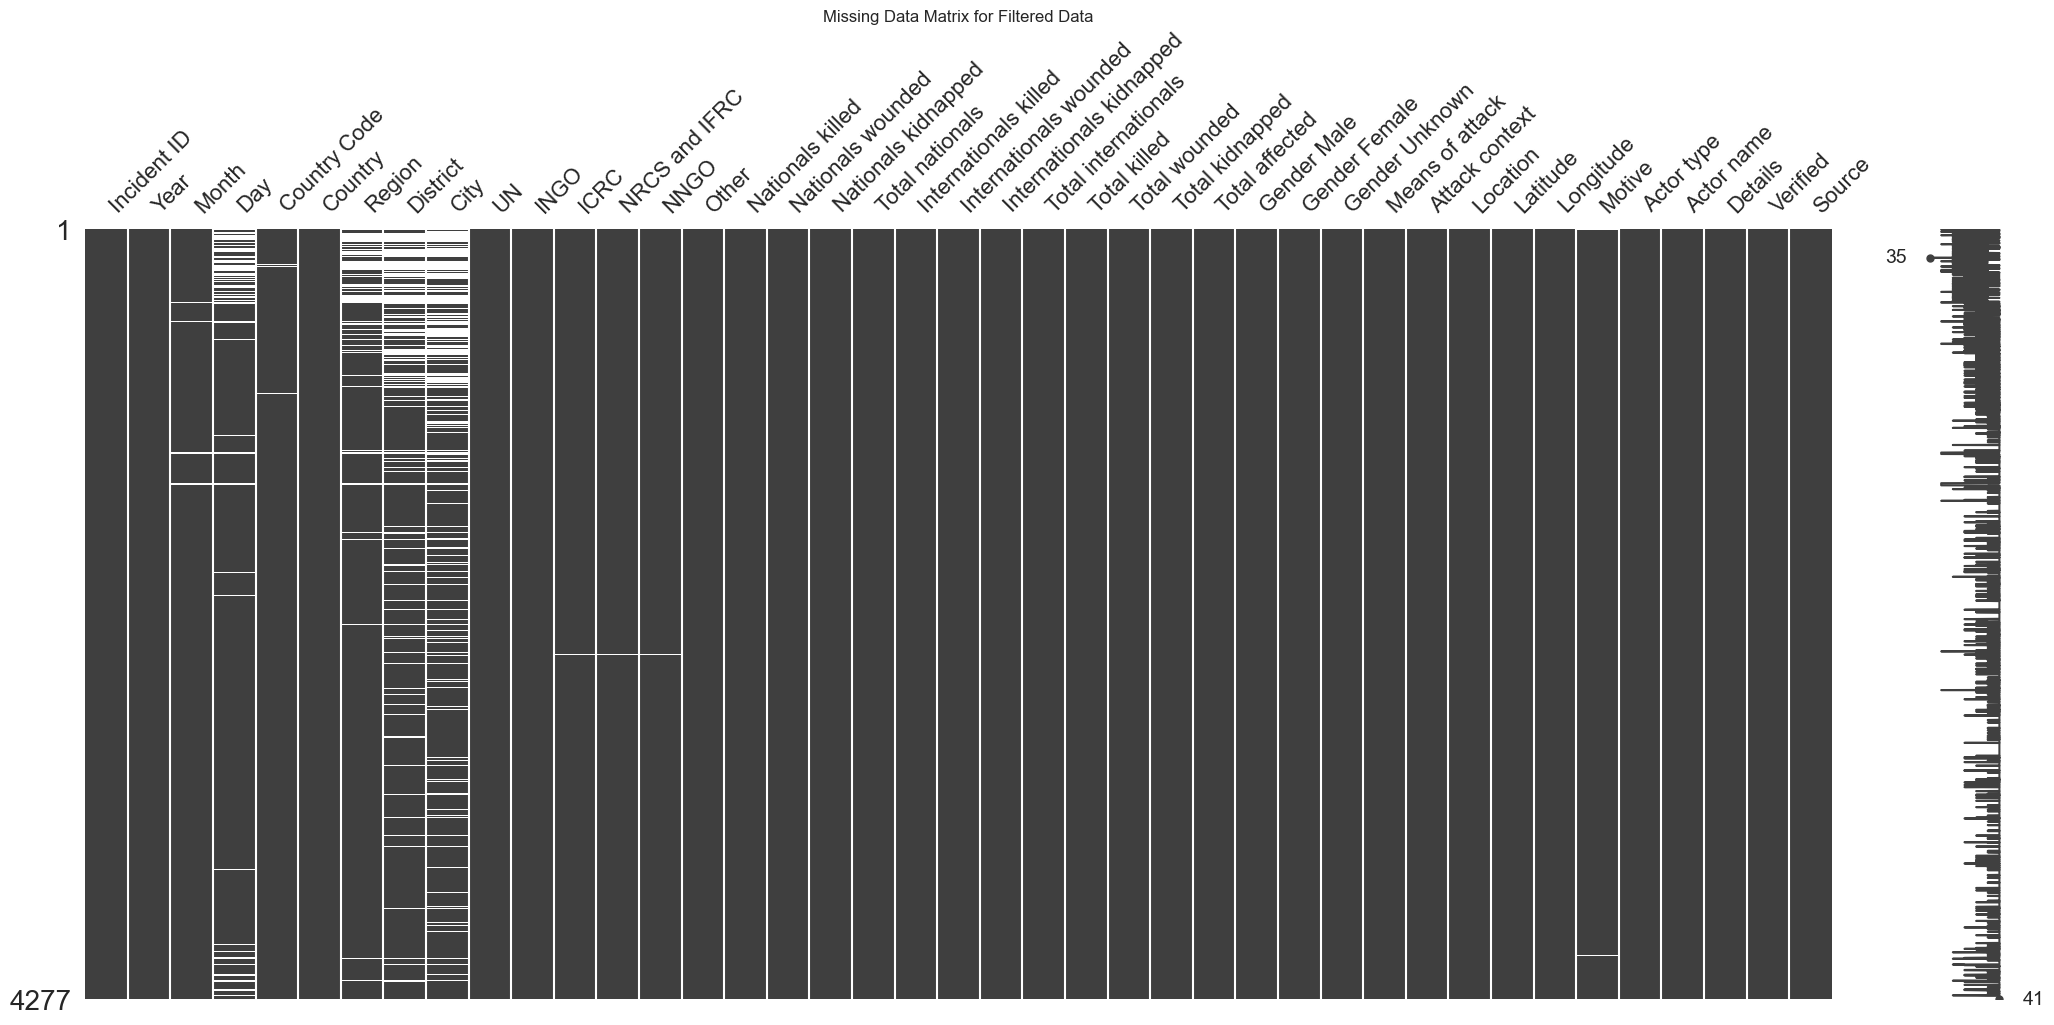

In [14]:
# Filter out rows missing lat or long
initial_rows = len(security_df)
filtered_df = security_df.dropna(subset=['Latitude', 'Longitude'])
filtered_df = filtered_df[filtered_df["Year"] < 2025]
filtered_rows = len(filtered_df)

# Print metrics
print(f"Initial rows: {initial_rows}")
print(f"Rows after filtering: {filtered_rows}")
print(f"Rows removed: {initial_rows - filtered_rows}")

# Generate and show missingness plot for the remaining data
msno.matrix(filtered_df)
plt.title("Missing Data Matrix for Filtered Data")
plt.show()

In [5]:
# simple_df = filtered_df.iloc[10:200] 
# simple_df
# simple_df.to_csv('./datasets/simple.csv', index=False)

filtered_df.to_csv('./datasets/filtered_security_df.csv', index=False)

In [16]:
# Basic structure and missing data inspection
summary = {
    "columns": filtered_df.columns.tolist(),
    "missing_values": filtered_df.isnull().sum(),
    "data_types": filtered_df.dtypes,
    "sample": filtered_df.sample(5, random_state=42)
}

# Yearly incident counts
yearly_counts = filtered_df['Year'].value_counts().sort_index()

# Total affected by year
affected_by_year = filtered_df.groupby('Year')[[
    'Total affected', 'Total killed', 'Total wounded', 'Total kidnapped'
]].sum().reset_index()

# Gender-based totals per year
gender_by_year = filtered_df.groupby('Year')[[
    'Gender Male', 'Gender Female', 'Gender Unknown'
]].sum().reset_index()

# Country-level incidents
country_counts = filtered_df['Country'].value_counts().head(15)

# Attack contexts
context_counts = filtered_df['Attack context'].value_counts().head(10)

# Actor types
actor_counts = filtered_df['Actor type'].value_counts().head(10)

Total incidents with data: 4324
Min: 0, Max: 92
Mean: 1.89, Median: 1.00
95th percentile: 5.0


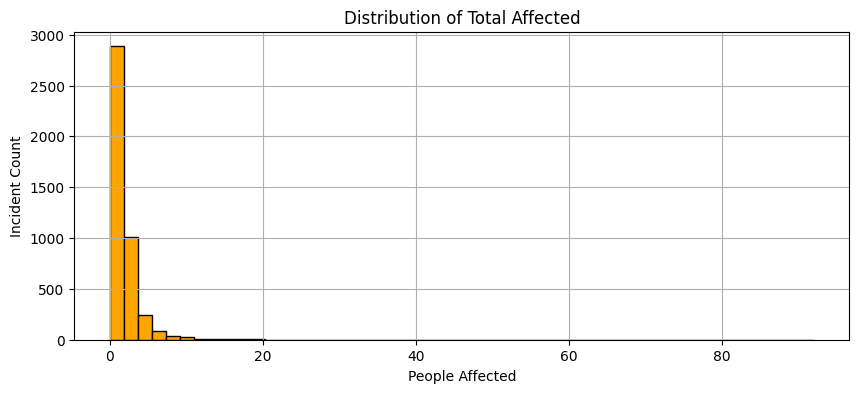

count    4324.000000
mean        1.886448
std         2.661801
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        92.000000
Name: Total affected, dtype: float64

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

def explore_total_affected(csv_path):
    df = pd.read_csv(csv_path)

    # Convert column to numeric (just in case there are strings)
    df['Total affected'] = pd.to_numeric(df['Total affected'], errors='coerce')

    # Drop missing or NaN values
    affected = df['Total affected'].dropna()

    print(f"Total incidents with data: {len(affected)}")
    print(f"Min: {affected.min()}, Max: {affected.max()}")
    print(f"Mean: {affected.mean():.2f}, Median: {affected.median():.2f}")
    print(f"95th percentile: {affected.quantile(0.95)}")

    # Plot distribution
    plt.figure(figsize=(10, 4))
    plt.hist(affected, bins=50, color='orange', edgecolor='black')
    plt.title("Distribution of Total Affected")
    plt.xlabel("People Affected")
    plt.ylabel("Incident Count")
    plt.grid(True)
    plt.show()

    return affected.describe()

explore_total_affected("./datasets/filtered_security_df.csv")

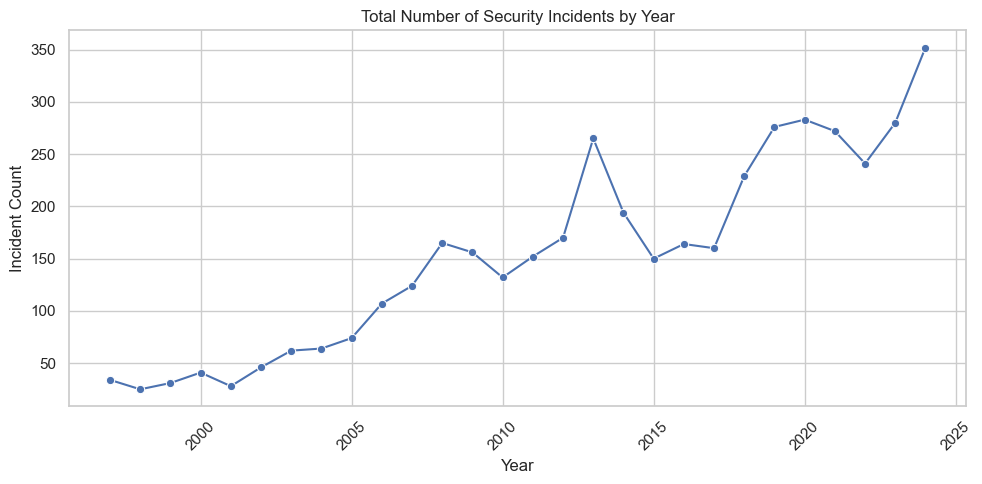

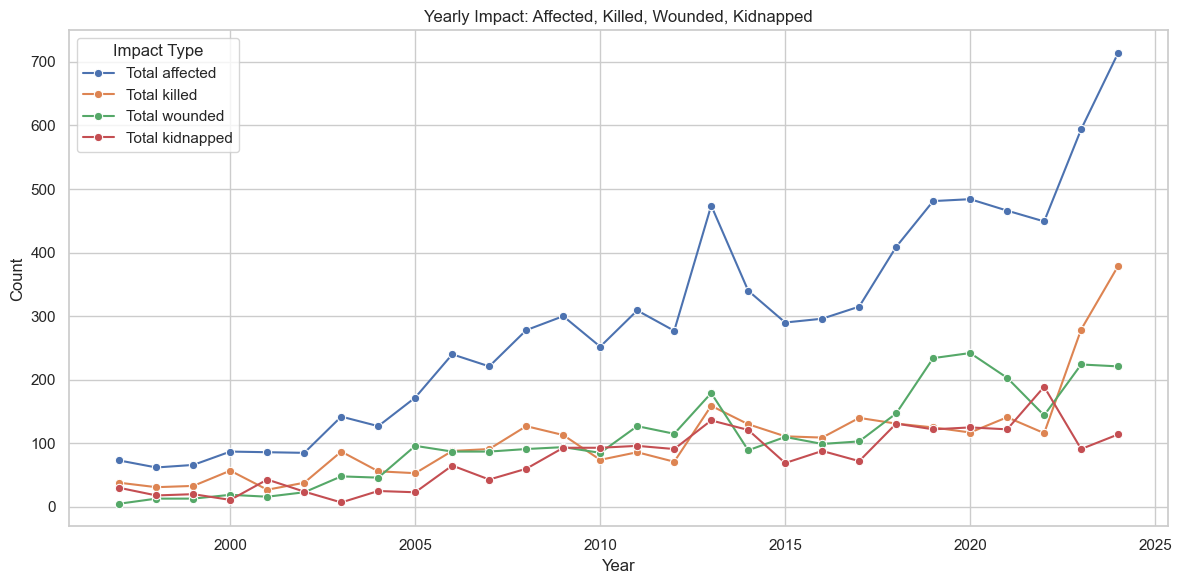

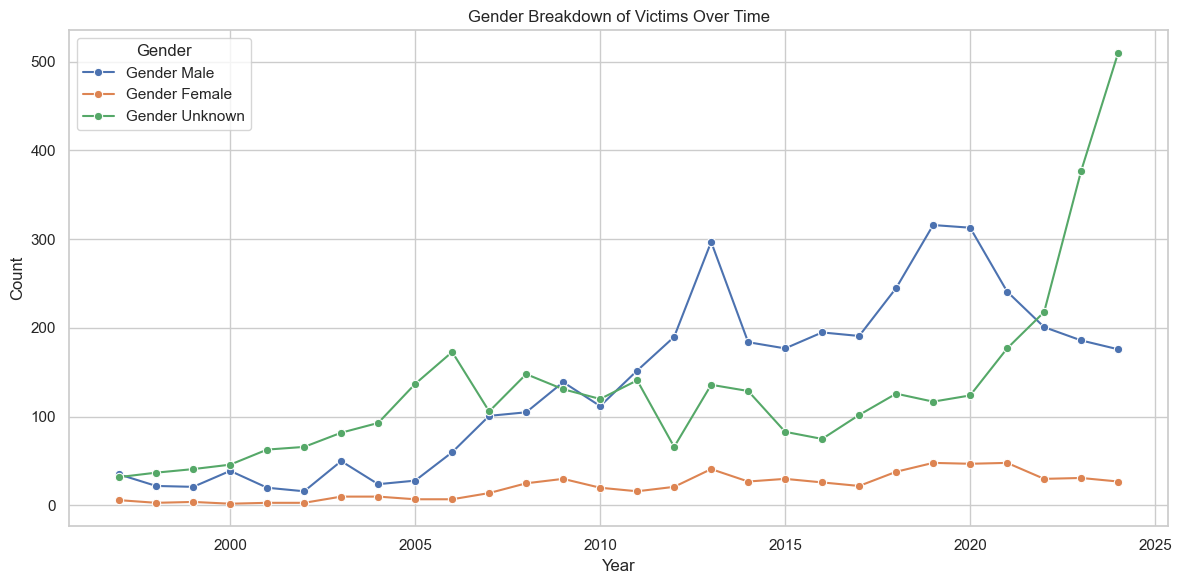

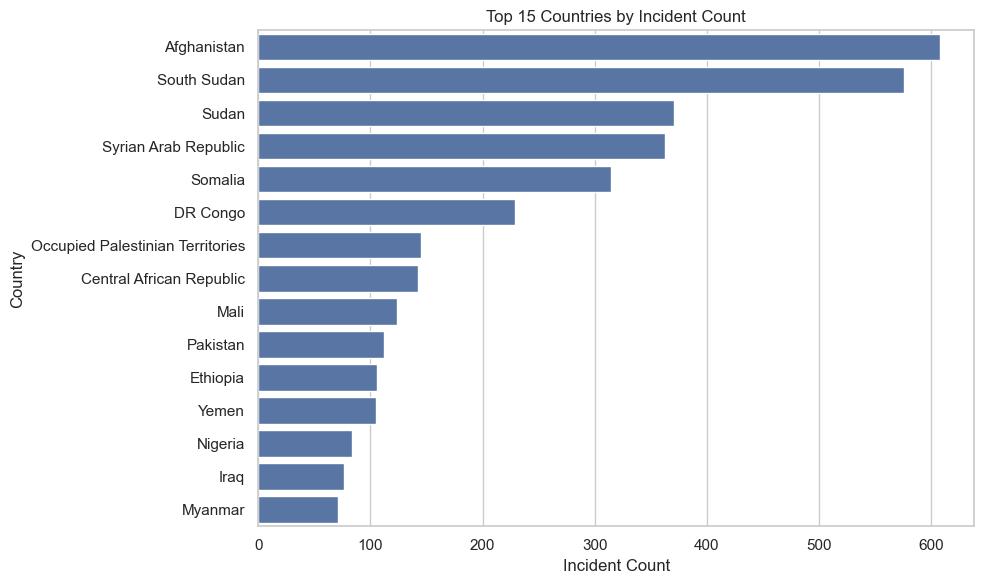

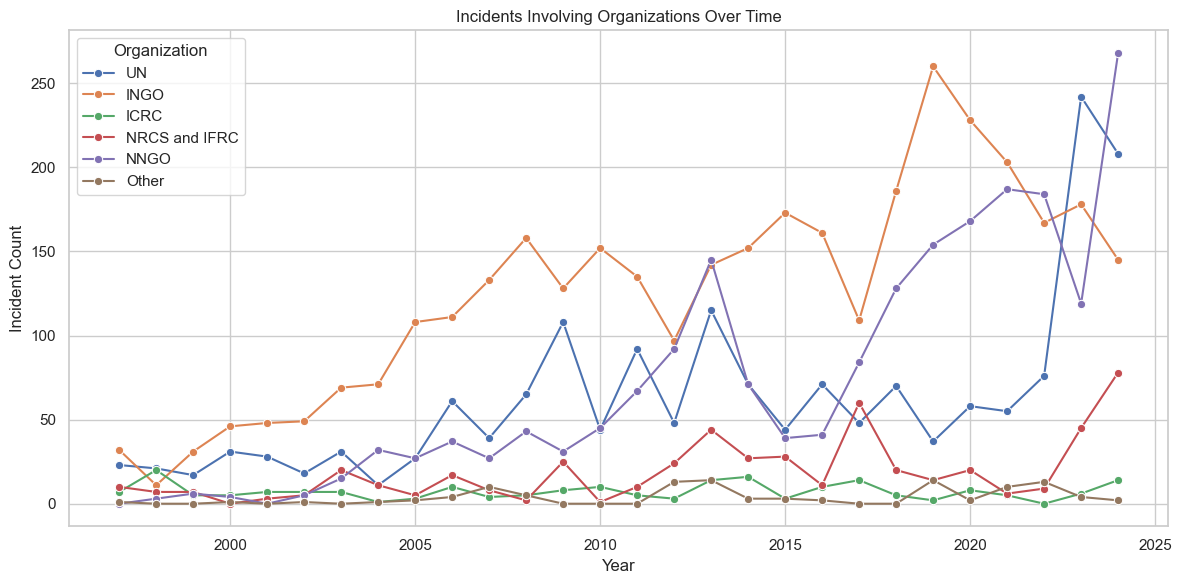

In [17]:
sns.set(style="whitegrid")

# 1. Incident count over time
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_counts.index, y=yearly_counts.values, marker="o")
plt.title("Total Number of Security Incidents by Year")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Total affected, killed, wounded, kidnapped over time
plt.figure(figsize=(12, 6))
melted_affected = affected_by_year.melt(id_vars="Year", var_name="Impact Type", value_name="Count")
sns.lineplot(data=melted_affected, x="Year", y="Count", hue="Impact Type", marker="o")
plt.title("Yearly Impact: Affected, Killed, Wounded, Kidnapped")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Impact Type")
plt.tight_layout()
plt.show()

# 3. Gender breakdown over time
plt.figure(figsize=(12, 6))
melted_gender = gender_by_year.melt(id_vars="Year", var_name="Gender", value_name="Count")
sns.lineplot(data=melted_gender, x="Year", y="Count", hue="Gender", marker="o")
plt.title("Gender Breakdown of Victims Over Time")
plt.xlabel("Year")
plt.ylabel("Count")
plt.legend(title="Gender")
plt.tight_layout()
plt.show()

# 4. Top 15 countries by total incident count
plt.figure(figsize=(10, 6))
sns.barplot(y=country_counts.index, x=country_counts.values)
plt.title("Top 15 Countries by Incident Count")
plt.xlabel("Incident Count")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

# 5. Organization involvement over time
# Sum all org columns by year
org_columns = ['UN', 'INGO', 'ICRC', 'NRCS and IFRC', 'NNGO', 'Other']
org_by_year = filtered_df.groupby('Year')[org_columns].sum().reset_index()

# Melt for plotting
melted_orgs = org_by_year.melt(id_vars="Year", var_name="Organization", value_name="Incident Count")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=melted_orgs, x="Year", y="Incident Count", hue="Organization", marker="o")
plt.title("Incidents Involving Organizations Over Time")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.legend(title="Organization")
plt.tight_layout()
plt.show()


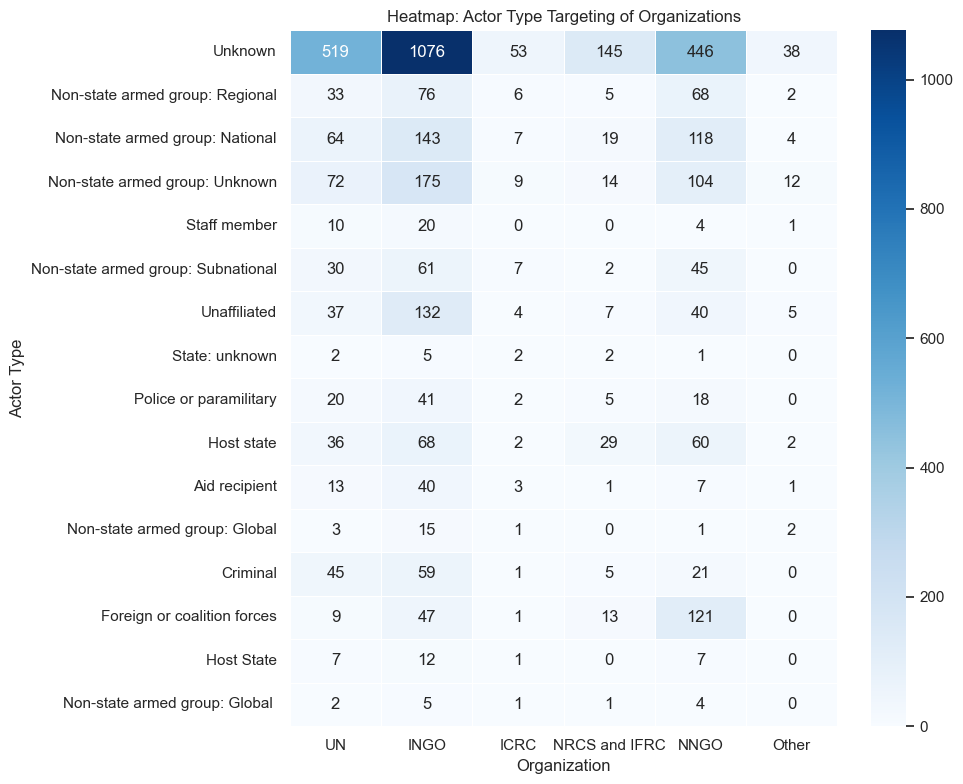

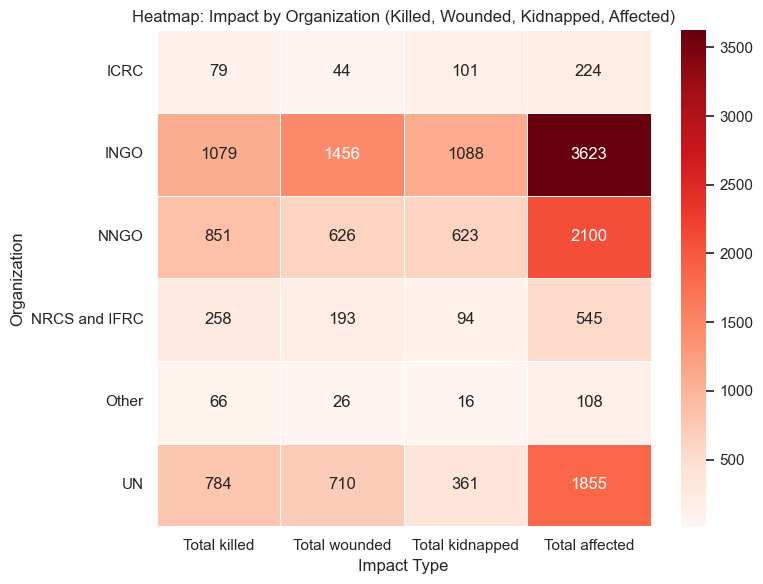

In [24]:
# 1. Create a pivot table: Actor Type vs. Organization
actor_org_matrix = pd.DataFrame(0, index=filtered_df["Actor type"].unique(), columns=org_columns)

# Fill in co-occurrence counts
for org in org_columns:
    sub_df = filtered_df[filtered_df[org] > 0]
    counts = sub_df["Actor type"].value_counts()
    actor_org_matrix.loc[counts.index, org] = counts.values

# Clean and remove low frequency actor types
actor_org_matrix = actor_org_matrix.loc[actor_org_matrix.sum(axis=1) > 5]

# 2. Create an Org vs. Impact matrix (sum values per org)
# Melt organizations first
org_melted = filtered_df.melt(id_vars=[
    'Total killed', 'Total wounded', 'Total kidnapped', 'Total affected'
], value_vars=org_columns, var_name="Organization", value_name="Present")

# Filter only rows where org was involved
org_melted = org_melted[org_melted["Present"] > 0]

# Group and sum impact columns by organization
impact_matrix = org_melted.groupby("Organization")[[
    'Total killed', 'Total wounded', 'Total kidnapped', 'Total affected'
]].sum()

# Plot heatmap: Actor type vs. Organization
plt.figure(figsize=(10, 8))
sns.heatmap(actor_org_matrix, cmap="Blues", linewidths=0.5, annot=True, fmt="d")
plt.title("Heatmap: Actor Type Targeting of Organizations")
plt.xlabel("Organization")
plt.ylabel("Actor Type")
plt.tight_layout()
plt.show()

# Plot heatmap: Organization vs. Impact
plt.figure(figsize=(8, 6))
sns.heatmap(impact_matrix, cmap="Reds", linewidths=0.5, annot=True, fmt="d")
plt.title("Heatmap: Impact by Organization (Killed, Wounded, Kidnapped, Affected)")
plt.xlabel("Impact Type")
plt.ylabel("Organization")
plt.tight_layout()
plt.show()
